# QMUL Multiview experiment

This notebook is an experiment aiming to compare the dimensionality reduction capabilities of the RTD-AE, compared to the classical autoencoder and other dimensionality reduction methods, using the [QMUL Multiview Face Dataset](http://www.eecs.qmul.ac.uk/~sgg/QMUL_FaceDataset/). Here, we want to compare the behavior of each dimensionality reduction method when there are "holes" in the initial distribution.

In [1]:
# Imports

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

from tqdm import tqdm

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

The dataset contains 36 sets of pictures of human faces, where each face was taken in horizontal angles ranging from 0 to 180 degrees, and vertical angles ranging from 60 to 120 degrees.

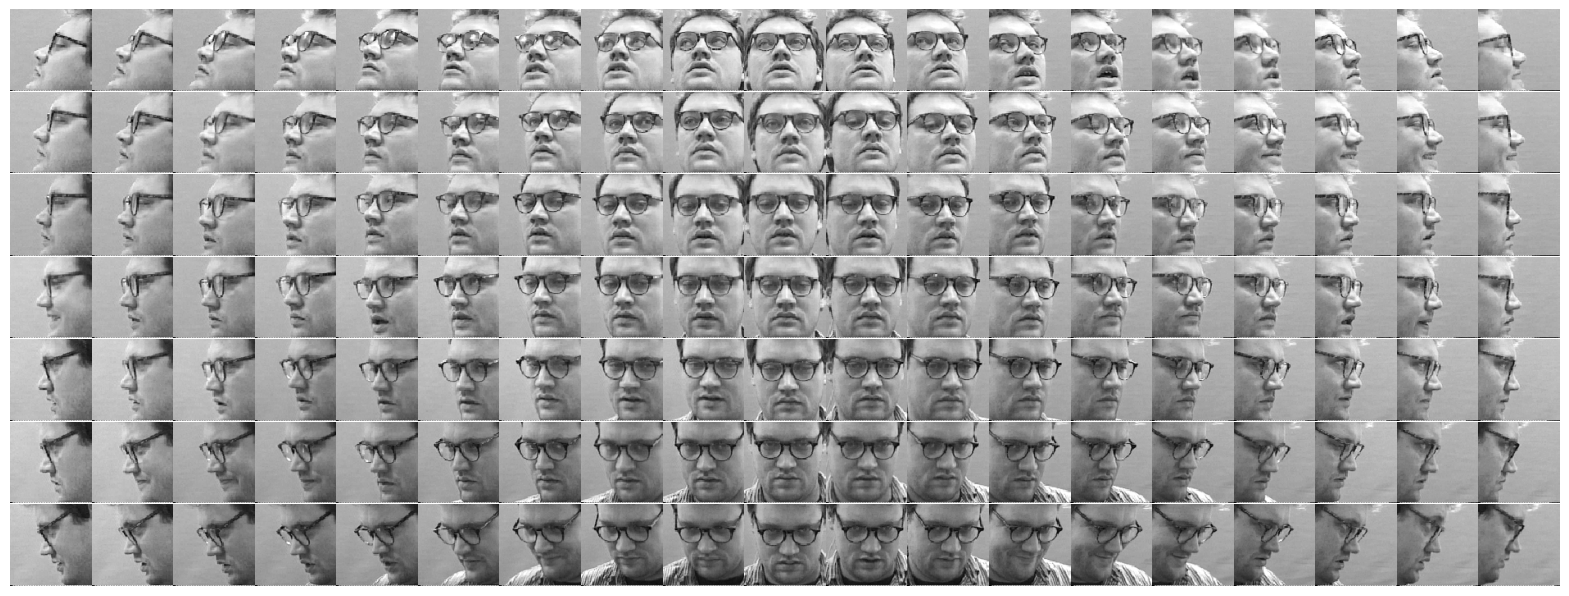

In [3]:
# Plot the images in the dataset
path = "data/QMUL/Set1_Greyscale/AdamBGrey"

x = ["060", "070", "080", "090", "100", "110", "120"]
y = ["000", "010", "020", "030", "040", "050", "060", "070", "080", "090", "100", "110", "120", "130", "140", "150", "160", "170", "180"]

fig, axs = plt.subplots(len(x), len(y), figsize=(20, 7.5))
for i in range(len(x)):
    for j in range(len(y)):
        img = Image.open(os.path.join(path, f"AdamB_{x[i]}_{y[j]}.ras"))
        axs[i, j].imshow(img, cmap="gray")
        axs[i, j].axis("off")
plt.subplots_adjust(wspace=0, hspace=0)
    

When training an autoencoder whcih take these greyscale images as input, with a latent space dimension of 2, we could hope that the autoencoder "learns" a two dimensional manifold, where one axis represents horizontal angles, and another vertical angles. Let us define first basic autoencoder architectures.

In [4]:
class VAE(nn.Module):
    def __init__(self, latent_dim=2):
        super(VAE, self).__init__()
        
        # Encoder network
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten()
        )
        
        # Latent space
        self.fc_mu = nn.Linear(256 * 6 * 6, latent_dim)
        self.fc_logvar = nn.Linear(256 * 6 * 6, latent_dim)
        
        # Decoder network
        self.fc_dec = nn.Linear(latent_dim, 256 * 6 * 6)
        
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (256, 6, 6)),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=0),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )
    
    def encode(self, x):
        x = self.encoder(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        z = self.fc_dec(z)
        return self.decoder(z)
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# VAE Loss Function (Reconstruction + KL Divergence)
def vae_loss(recon_x, x, mu, logvar):
    # Reconstruction loss (Binary Cross-Entropy)
    recon_loss = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    
    # KL divergence
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return recon_loss + kl_div


In [5]:
class AE(nn.Module):
    def __init__(self, latent_dim=2):
        super(AE, self).__init__()
        
        # Encoder network
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten()
        )
        
        # Latent space
        self.fc_enc = nn.Linear(256 * 6 * 6, latent_dim)
        
        # Decoder network
        self.fc_dec = nn.Linear(latent_dim, 256 * 6 * 6)
        
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (256, 6, 6)),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=0),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )
    
    def encode(self, x):
        x = self.encoder(x)
        z = self.fc_enc(x)
        return z
    
    def decode(self, z):
        z = self.fc_dec(z)
        return self.decoder(z)
    
    def forward(self, x):
        z = self.encode(x)
        return self.decode(z)

# AE Loss Function (Reconstruction)
def ae_loss(recon_x, x):
    # Reconstruction loss (Binary Cross-Entropy)
    recon_loss = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
        
    return recon_loss 


In [6]:
# PyTorch Dataset of the QMUL Multiview Face dataset
class QMULDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_folders = os.listdir(root_dir)

        self.images = []
        self.hor_angles = []
        self.ver_angles = []
        self.persons = []

        for folder in self.image_folders:
            if os.path.isdir(os.path.join(root_dir, folder)):
                self.images += [folder + "/" + img for img in os.listdir(os.path.join(root_dir, folder)) if img.endswith(".ras")]
                angles = [img.split("_")[1:] for img in os.listdir(os.path.join(root_dir, folder)) if img.endswith(".ras")]
                self.hor_angles += [int(angle[0]) for angle in angles]
                self.ver_angles += [int(angle[1].split(".")[0]) for angle in angles]     # remove .ras extension
                self.persons += [folder] * len(angles)
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.images[idx])
        image = Image.open(img_name)
        if self.transform:
            image = self.transform(image)
        return image
    
    def get_angles(self, idx):
        return self.hor_angles[idx], self.ver_angles[idx]
    
    def get_person(self, idx):
        return self.persons[idx]

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((100, 100)),
    transforms.ToTensor()
])

root_dir = "data/QMUL/Set1_Greyscale"
dataset = QMULDataset(root_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

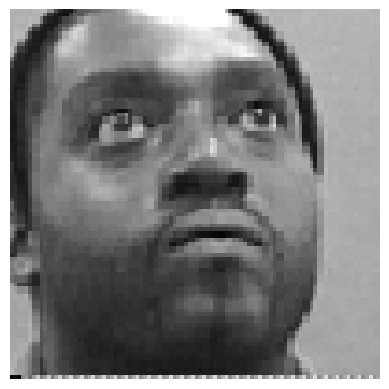

(60, 90)
ColinPGrey


In [7]:
# Plot an image from the dataset
idx = 500

img = dataset[idx].squeeze().numpy()
plt.imshow(img, cmap="gray")
plt.axis("off")
plt.show()

print(dataset.get_angles(idx))
print(dataset.get_person(idx))

Let us now train our autoencoder on the QMUL Multiview dataset, using a latent dimensionality of 2.

In [8]:
latent_dim = 2
model = AE(latent_dim=latent_dim).to(device)
# model = VAE(latent_dim=latent_dim).to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-3)

In [21]:
# Training Loop
epochs = 50

for epoch in range(epochs):
    model.train()
    train_loss = 0
    
    for batch in tqdm(dataloader):
        batch = batch.to(device)
        
        optimizer.zero_grad()
        
        # Forward pass
        # If training a VAE, the next line returns mu and logvar instead of just z, and replace ae_loss with vae_loss
        recon_batch = model(batch)              
        loss = ae_loss(recon_batch, batch)
        
        # Backward pass
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {train_loss / len(dataloader.dataset):.4f}')

100%|██████████| 143/143 [00:03<00:00, 40.23it/s]


Epoch [1/50], Loss: 6618.4451


100%|██████████| 143/143 [00:03<00:00, 42.97it/s]


Epoch [2/50], Loss: 6501.8388


100%|██████████| 143/143 [00:03<00:00, 43.00it/s]


Epoch [3/50], Loss: 6493.2732


100%|██████████| 143/143 [00:03<00:00, 43.40it/s]


Epoch [4/50], Loss: 6486.5203


100%|██████████| 143/143 [00:03<00:00, 43.18it/s]


Epoch [5/50], Loss: 6481.3056


100%|██████████| 143/143 [00:03<00:00, 43.05it/s]


Epoch [6/50], Loss: 6478.5717


100%|██████████| 143/143 [00:03<00:00, 42.91it/s]


Epoch [7/50], Loss: 6475.7218


100%|██████████| 143/143 [00:03<00:00, 42.83it/s]


Epoch [8/50], Loss: 6471.6887


100%|██████████| 143/143 [00:03<00:00, 42.87it/s]


Epoch [9/50], Loss: 6471.7264


100%|██████████| 143/143 [00:03<00:00, 43.23it/s]


Epoch [10/50], Loss: 6467.6565


100%|██████████| 143/143 [00:03<00:00, 43.14it/s]


Epoch [11/50], Loss: 6464.3079


100%|██████████| 143/143 [00:03<00:00, 43.49it/s]


Epoch [12/50], Loss: 6462.4761


100%|██████████| 143/143 [00:03<00:00, 43.04it/s]


Epoch [13/50], Loss: 6461.0426


100%|██████████| 143/143 [00:03<00:00, 42.68it/s]


Epoch [14/50], Loss: 6459.9394


100%|██████████| 143/143 [00:03<00:00, 43.64it/s]


Epoch [15/50], Loss: 6455.7539


100%|██████████| 143/143 [00:03<00:00, 42.91it/s]


Epoch [16/50], Loss: 6455.0542


100%|██████████| 143/143 [00:03<00:00, 42.47it/s]


Epoch [17/50], Loss: 6452.8456


100%|██████████| 143/143 [00:03<00:00, 42.24it/s]


Epoch [18/50], Loss: 6452.4368


100%|██████████| 143/143 [00:03<00:00, 42.95it/s]


Epoch [19/50], Loss: 6449.3719


100%|██████████| 143/143 [00:03<00:00, 43.29it/s]


Epoch [20/50], Loss: 6449.8976


100%|██████████| 143/143 [00:03<00:00, 43.34it/s]


Epoch [21/50], Loss: 6446.1523


100%|██████████| 143/143 [00:03<00:00, 43.04it/s]


Epoch [22/50], Loss: 6444.8719


100%|██████████| 143/143 [00:03<00:00, 44.00it/s]


Epoch [23/50], Loss: 6441.5612


100%|██████████| 143/143 [00:03<00:00, 43.06it/s]


Epoch [24/50], Loss: 6442.2965


100%|██████████| 143/143 [00:03<00:00, 44.85it/s]


Epoch [25/50], Loss: 6440.6475


100%|██████████| 143/143 [00:03<00:00, 44.71it/s]


Epoch [26/50], Loss: 6438.4500


100%|██████████| 143/143 [00:03<00:00, 44.81it/s]


Epoch [27/50], Loss: 6437.2186


100%|██████████| 143/143 [00:03<00:00, 44.36it/s]


Epoch [28/50], Loss: 6435.8158


100%|██████████| 143/143 [00:03<00:00, 44.67it/s]


Epoch [29/50], Loss: 6433.7614


100%|██████████| 143/143 [00:03<00:00, 44.88it/s]


Epoch [30/50], Loss: 6431.9110


100%|██████████| 143/143 [00:03<00:00, 44.32it/s]


Epoch [31/50], Loss: 6431.0936


100%|██████████| 143/143 [00:03<00:00, 45.32it/s]


Epoch [32/50], Loss: 6429.3904


100%|██████████| 143/143 [00:03<00:00, 44.54it/s]


Epoch [33/50], Loss: 6429.6810


100%|██████████| 143/143 [00:03<00:00, 44.47it/s]


Epoch [34/50], Loss: 6429.6553


100%|██████████| 143/143 [00:03<00:00, 44.85it/s]


Epoch [35/50], Loss: 6426.8676


100%|██████████| 143/143 [00:03<00:00, 44.85it/s]


Epoch [36/50], Loss: 6424.9414


100%|██████████| 143/143 [00:03<00:00, 44.81it/s]


Epoch [37/50], Loss: 6424.8247


100%|██████████| 143/143 [00:03<00:00, 44.99it/s]


Epoch [38/50], Loss: 6422.1867


100%|██████████| 143/143 [00:03<00:00, 44.42it/s]


Epoch [39/50], Loss: 6422.8031


100%|██████████| 143/143 [00:03<00:00, 44.38it/s]


Epoch [40/50], Loss: 6421.0872


100%|██████████| 143/143 [00:03<00:00, 44.29it/s]


Epoch [41/50], Loss: 6422.0113


100%|██████████| 143/143 [00:03<00:00, 44.35it/s]


Epoch [42/50], Loss: 6420.1384


100%|██████████| 143/143 [00:03<00:00, 44.59it/s]


Epoch [43/50], Loss: 6417.2676


100%|██████████| 143/143 [00:03<00:00, 44.66it/s]


Epoch [44/50], Loss: 6415.6229


100%|██████████| 143/143 [00:03<00:00, 44.36it/s]


Epoch [45/50], Loss: 6417.7154


100%|██████████| 143/143 [00:03<00:00, 44.39it/s]


Epoch [46/50], Loss: 6416.6639


100%|██████████| 143/143 [00:03<00:00, 44.26it/s]


Epoch [47/50], Loss: 6414.3700


100%|██████████| 143/143 [00:03<00:00, 44.31it/s]


Epoch [48/50], Loss: 6415.1486


100%|██████████| 143/143 [00:03<00:00, 44.72it/s]


Epoch [49/50], Loss: 6413.5152


100%|██████████| 143/143 [00:03<00:00, 44.98it/s]

Epoch [50/50], Loss: 6412.1641


We can look at the reconstructions from our model of each image in the original dataset. Obvisouly, they are pretty blurry and of poor quality, since we reduced from $[0,1]^{100\times 100}$ to $\mathbb{R}^2$, but we can at least have a sense of the orientation of the original face in the reconstruction. This is a good sign!

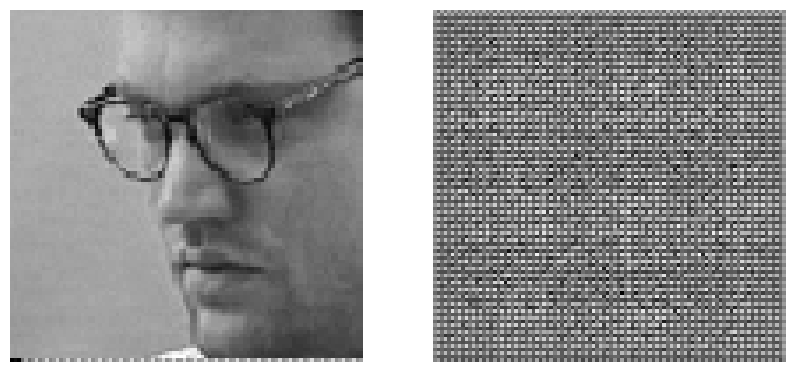

In [9]:
idx = 100
original = dataset[idx].squeeze().numpy()
reconstruct = model(dataset[idx].view(1,1,100,100).to(device))[0].cpu().squeeze().detach().numpy()

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(original, cmap="gray")
axs[0].axis("off")
axs[1].imshow(reconstruct, cmap="gray")
axs[1].axis("off")
plt.show()

Let's now plot in the XY plane the latent variables associated with each picture in the dataset, along with the horizontal and vertical orientations associated with each picture.

In [23]:
N = len(dataset)

X = np.zeros(N)
Y = np.zeros(N)
hor_angle = dataset.hor_angles
ver_angle = dataset.ver_angles

for i in range(N):
    img = dataset[i].unsqueeze(0).to(device)
    with torch.no_grad():
        z = model.encode(img)
        X[i] = z[0].cpu().numpy()[0]
        Y[i] = z[0].cpu().numpy()[1]

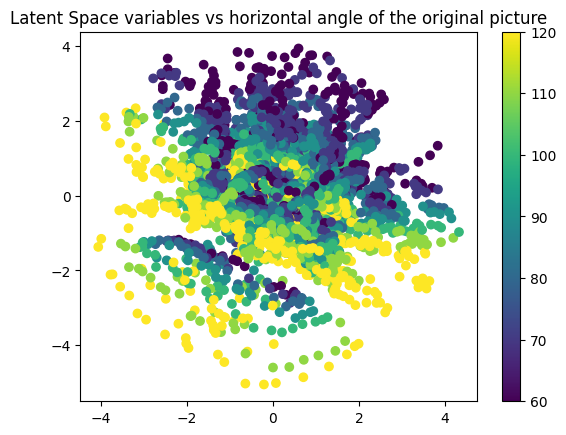

In [24]:
plt.scatter(X, Y, c=hor_angle, cmap="viridis")
plt.title("Latent Space variables vs horizontal angle of the original picture")
plt.colorbar()

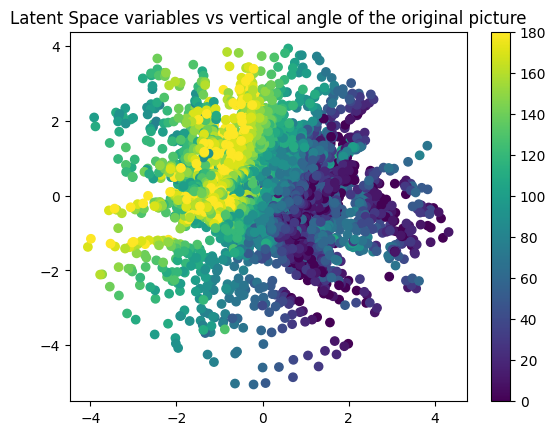

In [25]:
plt.scatter(X, Y, c=ver_angle, cmap="viridis")
plt.title("Latent Space variables vs vertical angle of the original picture")
plt.colorbar()

It seems that the model retrieved that the two main axes of the manifold we were trying to learn are tied to the horizontal and vertical angle at which the pictures are taken.

## RTD AE

In [85]:
from src.rtd import RTDLoss
from src.autoencoder import AutoEncoder
from src.utils import get_geodesic_distance

import pytorch_lightning as pl

In [19]:
config = {
    "dataset_name":"COIL-20",
    "version":"d16",
    "model_name":"default",
    "max_epochs":400,
    "gpus":[0],
    "rtd_every_n_batches":1,
    "rtd_start_epoch":0,
    "rtd_l":1.0, # rtd loss 
    "n_runs":1, # number of runs for each model
    "card":50, # number of points on the persistence diagram
    "n_threads":50, # number of threads for parallel ripser computation of pers homology
    "latent_dim":16, # latent dimension (2 or 3 for vizualization purposes)
    "input_dim":128*128,
    "n_hidden_layers":3,
    "hidden_dim":512,
    "batch_size":256,
#     "width":80,
#     "heigth":80,
    "engine":"ripser",
    "is_sym":True,
    "lr":5e-4
#     'mode':'minimum',
#     'lp':1.0
}

In [51]:
class QMULDataset4RTD(Dataset):

    def __init__(self, root_dir, transform=None, **kwargs):
        self.root_dir = root_dir
        self.transform = transform
        self.image_folders = os.listdir(root_dir)

        self.images = []
        self.hor_angles = []
        self.ver_angles = []
        self.persons = []

        for folder in self.image_folders:
            if os.path.isdir(os.path.join(root_dir, folder)):
                self.images += [folder + "/" + img for img in os.listdir(os.path.join(root_dir, folder)) if img.endswith(".ras")]
                angles = [img.split("_")[1:] for img in os.listdir(os.path.join(root_dir, folder)) if img.endswith(".ras")]
                self.hor_angles += [int(angle[0]) for angle in angles]
                self.ver_angles += [int(angle[1].split(".")[0]) for angle in angles]     # remove .ras extension
                self.persons += [folder] * len(angles)

        self.N = len(self.images)
        self.data = torch.zeros(self.N, 1, 100, 100)
        for i in range(self.N):
            img_name = os.path.join(self.root_dir, self.images[i])
            image = Image.open(img_name)
            if self.transform is not None:
                image = self.transform(image)
            self.data[i] = image

        self.flattened_data = self.data.view(self.N, -1)
        self.data_dist = torch.Tensor(get_geodesic_distance(self.flattened_data, **kwargs))
        

    def __len__(self):
        return self.N
    
    def __getitem__(self, idx):
        return idx, self.data[idx], 0, self.data_dist[idx]

    def get_angles(self, idx):
        return self.hor_angles[idx], self.ver_angles[idx]
    
    def get_person(self, idx):
        return self.persons[idx]


transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((100, 100)),
    transforms.ToTensor()
])


dataset = QMULDataset4RTD(root_dir, transform=transform)

N connected: 1


In [77]:
x = torch.randn(1, 1, 100, 100)
idxs = torch.Tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]).int()
x[:,:,idxs,:].shape

torch.Size([1, 1, 10, 100])

In [81]:
def collate(samples):
    idx, data, labels, data_dist = zip(*samples)
    indices = torch.tensor(idx)
    data_dist = torch.stack(data_dist)
    data_dist = data_dist[:,indices]
    return torch.stack(data), data_dist, torch.tensor(labels)

loader = DataLoader(
    dataset, 
    batch_size=config["batch_size"], 
    num_workers=1, 
    collate_fn=collate,
    shuffle=True
)

In [83]:
encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(256 * 6 * 6, 2)
        )

decoder = nn.Sequential(
            nn.Linear(2, 256 * 6 * 6),
            nn.Unflatten(1, (256, 6, 6)),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=0),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )

model = AutoEncoder(encoder = encoder, decoder = decoder, RTDLoss = RTDLoss(dim = 1, lp = 1., **config), MSELoss = nn.MSELoss()).to(device)

In [ ]:
max_epochs = 50

version = f"a"
logger = pl.loggers.TensorBoardLogger(save_dir=os.getcwd(), name='lightning_logs', version=version)
trainer = pl.Trainer(
        logger=logger, 
        devices=[0], 
        max_epochs=max_epochs, 
        log_every_n_steps=1, 
        num_sanity_val_steps=0
    )
trainer.fit(model, loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type       | Params | Mode 
----------------------------------------------------
0 | encoder      | Sequential | 707 K  | train
1 | decoder      | Sequential | 716 K  | train
2 | RTDLoss      | RTDLoss    | 0      | train
3 | MSELoss      | MSELoss    | 0      | train
  | other params | n/a        | 1      | n/a  
----------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.696     Total estimated model params size (MB)
25        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]